# Benchmarking metrics

In this tutorial we will introduce the `galpynostatic.metric` module for benchmarking fast charging electrode materials.

First, we will import the libraries that we will use throughout this example.

In [1]:
import galpynostatic as gp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

and load the experimental dataset collected and used by [Xia et al.](https://doi.org/10.1021/acsnano.2c03922)

In [2]:
dataset = pd.read_csv("../_static/benchmarking_experimental_data.csv")

## Data cleaning

First we will clean the experimental dataset to have it in a proper form for the metric module.

In [3]:
dataset.head()

,Material,particle_size_micro,dcoeff_cm2s
0,Ternary,10,7.8e-11
1,Ternary,8,1.7e-11 to 6.5e-9
2,Ternary,2-5,1e-11 to 3e-11
3,LCO,5-10,1e-11 to 1e-7
4,LCO,NaN,1e-10 to 1.5e-9


We can see that the particle size is given in microns and the range values are separated by a '-'.

In [4]:
dataset["d_mean_micro"] = dataset["particle_size_micro"].str.split("-").apply(
    lambda x: np.mean([float(i) for i in x]) 
    if isinstance(x, list) 
    else np.nan
)

there are also missing values, which we fill in with the mean value of the material group

In [5]:
dataset["d_mean_micro"] = dataset.groupby(
    "Material", group_keys=False
)["d_mean_micro"].apply(lambda x: x.fillna(x.mean()))

In the case of the diffusion coefficient, the range is separated by the characters ` to ` and they are spread over a wide range of orders of magnitude, so we use the geometric mean because it is a more appropriate measure than the arithmetic mean, which would be dominated by the larger ones.

In [6]:
from scipy.stats import gmean

dataset["dcoeff_midpoint_cm2s"] = dataset["dcoeff_cm2s"].str.split(" to ").apply(
    lambda x: gmean([float(i) for i in x])
)

## Figure of Merit

This metric uses the diffusion coefficient and the particle size to define the characteristic time of diffusion, $\tau = d^2 / D$. The greater this value, the greater the fast charging capability of the material.

In [7]:
dataset["fom"] = gp.metric.fom(
    1e-4 * dataset["d_mean_micro"], dataset["dcoeff_midpoint_cm2s"]
)

In this case, we generate a chart similar to the one presented by [Xia et al.](https://doi.org/10.1021/acsnano.2c03922)

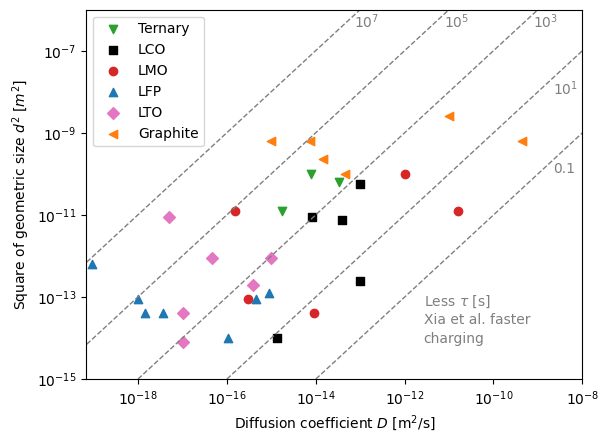

In [8]:
fig, ax = plt.subplots() 

xvalues = np.logspace(-20, -8)
for tau, x, y in zip(
    np.logspace(7, -1, num=5), 
    [0.54, 0.72, 0.9, 0.94, 0.94], 
    [0.95, 0.95, 0.95, 0.77, 0.56],
):
    ax.plot(xvalues, tau * xvalues, color="tab:gray", linestyle="dashed", linewidth=1)
    exp = np.log10(tau)
    txt = fr"10$^{exp:.0f}$" if exp > 0 else f"{tau:.1f}"
    ax.text(x, y, txt, c="tab:gray", transform=ax.transAxes)
    
ax.text(0.68, 0.2, r"Less $\tau$ [s]", c="tab:gray", transform=ax.transAxes)
ax.text(0.68, 0.15, r"Xia et al. faster", c="tab:gray", transform=ax.transAxes)
ax.text(0.68, 0.1, r"charging", c="tab:gray", transform=ax.transAxes)

marker, color = {}, {}
for material, m, c in zip(
    ("LCO", "LMO", "LTO", "LFP", "Ternary", "Graphite"), 
    ("s", "o", "D", "^", "v", "<"), 
    (None, "red", "pink", "blue", "green", "orange")
):
    marker[material] = m
    color[material] = f"tab:{c}" if c is not None else "k"

for m, d, dcoeff, tau in dataset[
    ["Material", "d_mean_micro", "dcoeff_midpoint_cm2s", "fom"]
].values:
    ax.scatter(1e-4 * dcoeff, (1e-6 * d)**2, marker=marker[m], color=color[m], label=m)

ax.set_xlim((7e-20, 1e-8))
ax.set_xlabel(r"Diffusion coefficient $D$ [m$^2$/s]")
ax.set_xscale("log")

ax.set_ylim((1e-15, 1e-6))
ax.set_ylabel(r"Square of geometric size $d^2$ [$m^2$]")
ax.set_yscale("log")

handles, labels = ax.get_legend_handles_labels()
unique_labels, unique_handles = {}, []
for label, handle in zip(labels, handles):
    if label not in unique_labels:
        unique_labels[label] = handle
        unique_handles.append(handle)

ax.legend(unique_handles, unique_labels.keys())

plt.show()

## UMBEM

This Universal Metric for Benchmarking fast-charging Electrode Materials is defined as the State-of-Charge reached when a material is charged for 15 minutes under constant current conditions. It gives possible values between 0 and 1 and it is directly the percentage of charge retained.

In [9]:
dataset["full_umbem"] = [
    gp.metric.umbem(
        {"d": 1.0e-4 * d, "dcoeff_": dcoeff, "k0_": 5.0e-8}, full_output=True
    )
    for m, d, dcoeff, tau in dataset[
        ["Material", "d_mean_micro", "dcoeff_midpoint_cm2s", "fom"]
    ].values
]

This full_output returns not only the umbem value, but also if it meets the fast charging criteria ($\text{UMBEM} \geq 0.8$), and a `GalvanostaticRegressor` object to plot each material in the map and make predictions.

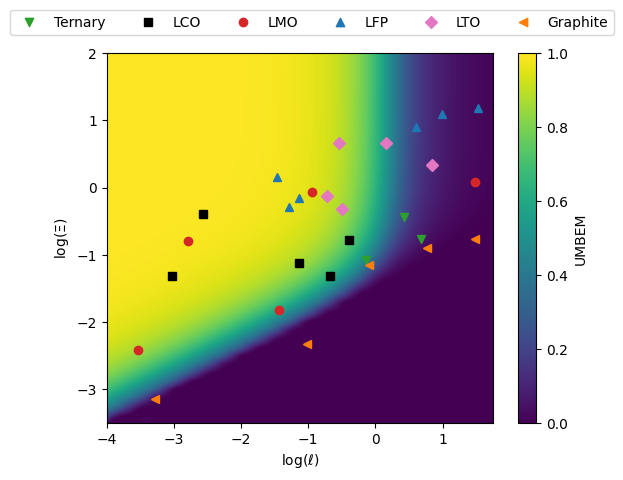

In [10]:
fig, ax = plt.subplots()
dataset["full_umbem"][0]["greg"].plot.render_map(ax=ax, clb_label="UMBEM")

for m, material in dataset[["Material", "full_umbem"]].values:
    ax = material["greg"].plot.in_render_map(
        np.array([[4.0]]), ax=ax, marker=marker[m], color=color[m], label=m
    )
    
ax.set_xlim((-4, 1.75))
ax.set_ylim((-3.5, 2))

ax.legend(unique_handles, unique_labels.keys(), ncol=6, loc=(-0.25, 1.05))

plt.show()

We can see here which materials are classified as fast charging ones (yellow zone) and which are not (purple zone).